# Planar quadrotor: description
In this Jupyter notebook, the example of the planar quadrotor is analysed. The MPC schemes that are used are:
- Tube-MPC, no GP: consists of the nominal MPC, with a tube in addition. The tube does not show theoretical guarantees, but is used to test a simpler formulation of the optimal control problem.
- RMPC, with GP, open-loop: used to obtain the solution at time step $k=0$. 
- RMPC, with GP, closed-loop: in this case, the optimisation problem is solved repeatedly, and we apply feedback between each solve.
- RAMPC, with GP, closed-loop: in this case, the optimisation problem is solved repeatedly, and we apply feedback between each solve.

For each of the corresponding optimal control problem (OCP), optional arguments can be changed to obtained the desired setting. For example "initial_con_z=True" denotes the case where we have an explicit initial constraint of the type  $z_0=x(0)$. Importantly, it is needed to change the model name of the OCP if the same residual model is used successively.

In [1]:
import sys, os
sys.path += ["../../"]
import timeit
import numpy as np
from scipy.stats import norm
import scipy.io
import casadi as cas
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy
import importlib

# Systems' dynamics imports
import ra_gpmpc_utils.dynamics
importlib.reload(ra_gpmpc_utils.dynamics)
from ra_gpmpc_utils.dynamics import NonlinearSystemNoGP, TubeDynamicsNoGP, SystemAndTubeDynamicsNoGP
from ra_gpmpc_utils.dynamics import NonlinearSystemGP, TubeDynamicsGP, SystemAndTubeDynamicsGP
from ra_gpmpc_utils.dynamics import NonlinearSystemReal, SystemAndTubeDynamicsGPMultiLambda

# Estimator functions (provide \bar{g} and w)
import ra_gpmpc_utils.estimators
importlib.reload(ra_gpmpc_utils.estimators)
from ra_gpmpc_utils.estimators import EstimateAndBoundSingleGP, EstimateAndBoundMultiLambda

# Integrator functions
from ra_gpmpc_utils.integrators import TimeIntegrator, ResidualTimeIntegration

# Acados ocp and model imports
import quadrotor_model_acados
importlib.reload(quadrotor_model_acados)
from quadrotor_model_acados import export_ocp_quadrotor_RMPC, export_ocp_quadrotor_RAMPC

# zoRO imports
from zero_order_gpmpc.controllers import ResidualLearningMPC

# GPyTorch imports
import gpytorch_utils.gp_hyperparam_training
importlib.reload(gpytorch_utils.gp_hyperparam_training)
import gpytorch_utils.gp_utils
importlib.reload(gpytorch_utils.gp_utils)
from gpytorch_utils.gp_hyperparam_training import generate_training_positions_as_grid, generate_g_outputs_at_training_inputs
from gpytorch_utils.gp_hyperparam_training import train_GP_models_as_batch_with_nan, set_hyperparameters_to_first_dimension, print_hyperparameters_of_batch
from gpytorch_utils.gp_utils import plot_gp_models_in_batch_quadrotor
from gpytorch_utils.gp_model import BatchGPModel

# Simulation functions (closed-loop) imports
import ra_gpmpc_utils.simulation
importlib.reload(ra_gpmpc_utils.simulation)
from ra_gpmpc_utils.simulation import simulate_real_system_RK4_1_sn_RMPC, simulate_real_system_RK4_1_sn

from ra_gpmpc_utils.utils import construct_function_coef_monomials 


# Plotting functions imports
import ra_gpmpc_utils.plotting
importlib.reload(ra_gpmpc_utils.plotting)
from ra_gpmpc_utils.plotting import EllipsoidData2D, plot_sol_tube_obstacle, plot_state_input_solution_quadrotor, plot_single_state, add_plot_trajectory,base_plot
cm = 1/2.54

# Define model parameters and important classes

We model the planar quadcopter as follows:

$$
f_w(x,u,g,d) 
        =
        \begin{bmatrix}
             v_1 - v_2\phi  \\
             v_1\phi + v_2  \\
             \dot{\phi}                     \\
             v_2\dot{\phi} - g\sin(\phi)    \\
             -v_1\dot{\phi} - g\cos(\phi)   \\
             0
        \end{bmatrix}
        +
        \begin{bmatrix}
            0   &   0   \\
            0   &   0   \\
            0   &   0   \\
            0   &   0   \\
            \frac{1}{m} &   \frac{1}{m} \\
            \frac{l}{J} &   \frac{-l}{J}  
        \end{bmatrix}
        \begin{bmatrix}
            u_1     \\
            u_2
        \end{bmatrix}
        +
        \begin{bmatrix}
           1    \\
           0    \\
           0    \\
           0    \\
           0    \\
           0      
        \end{bmatrix}
        \left(
            v_1(\cos(\phi)-1) - v_2(\sin(\phi)-\phi) 
        \right)
        +
        \begin{bmatrix}
            0   \\
            0   \\
            0   \\
            \cos(\phi)  \\
            -\sin(\phi) \\
            0
        \end{bmatrix}
        d
$$

In [3]:
# Define horizon 
N = 240
h = 0.025
T = N*h

# Load offline data
constants_offline_file = 'Quadrotor_offline_constants_0.94616_6'
current_working_dir = os.getcwd()
constants_offline_file_path = os.path.abspath(os.path.join(os.path.dirname(current_working_dir),'..','..', 'offline_constants',constants_offline_file))
constants_offline = scipy.io.loadmat(constants_offline_file_path, squeeze_me=True) 

# System quantities
m  = constants_offline['m']
J = constants_offline["J"]
l = constants_offline["l"]
B = torch.tensor(np.array([[0.,0.],
                           [0.,0.],
                           [0.,0.],
                           [0.,0.],
                           [1/m,1/m],
                           [l/J,-l/J]])).float()

G = torch.tensor(np.array([[1.],
                           [0.],
                           [0.],
                           [0.],
                           [0.],
                           [0.]])).float()

# Define the nonlinear function f(x), specific to the quadrotor system
# Note: x has the shape (n_shooting_nodes,nx)
def f(x):
    # element-wise operations
    f1 = x[:,3] * 1 - x[:,4] * x[:,2]
    f2 = x[:,3] * torch.sin(x[:,2]) + x[:,4] * torch.cos(x[:,2])
    f3 = x[:,5]
    f4 = x[:,4] * x[:,5] - 9.81 * torch.sin(x[:,2])
    f5 = -x[:,3] * x[:,5] - 9.81 * torch.cos(x[:,2])
    f6 = torch.zeros_like(x[:,5])
    return torch.stack((f1, f2, f3, f4, f5, f6), dim=1)

nx_system = B.shape[0] 
nu_system = B.shape[1]
g_sys_state_idx = [2,3,4]   # the unkonwn function g is a function of x(2)=\phi,x(3)=v1,x(4)=v2

# Function g of true dynamics (for simulation)
# Note: the function g takes the whole state x as an input
def g(x):
    return x[3] * (torch.cos(x[2])-1) - x[4] * (torch.sin(x[2]) - x[2])
  
# Evaluation of g as a function of \phi,v1,v2 (for offline training)
# Note: the function g_eval takes an argument x_training of size n_GP_inputs (3),
# and contains only the states x needed to evaluate the function 
def g_eval(x_training):
    phi = x_training[0]
    v1 = x_training[1]
    v2 = x_training[2]
    return v1*(torch.cos(phi)-1) - v2*(torch.sin(phi)-phi)  

# Define the nonlinear function f(x), specific to the quadrotor system. Used for single step simulation only
# Note: x has the shape (nx,1)
def f_real(x):
    # element-wise operations
    f1 = x[3] * 1 - x[4] * x[2]
    f2 = x[3] * torch.sin(x[2]) + x[4] * torch.cos(x[2])
    f3 = x[5]
    f4 = x[4] * x[5] - 9.81 * torch.sin(x[2])
    f5 = -x[3] * x[5] - 9.81 * torch.cos(x[2])
    f6 = torch.zeros_like(x[5])
    return torch.stack((f1, f2, f3, f4, f5, f6), dim=0) 

# Tube constants
L_G = constants_offline['L_G']
G_M = constants_offline['G_M']
E_M = constants_offline['E_M']
beta = 5.0       # TODO: change for bound of paper

# W_fcn and Y_fcn, take x[2] and x[3] as arguments (W parametrised using \phi and v1)
W_coef = constants_offline['W_coef']
Y_coef = constants_offline['Y_coef']
monomial_degree = constants_offline['monomial_degree']
rho = constants_offline['rho']
W_fcn = construct_function_coef_monomials(W_coef,monomial_degree)
Y_fcn = construct_function_coef_monomials(Y_coef,monomial_degree)

# batch GP related quantities
n_gp_models_in_batch = 8
n_data_points_in_batch = 200

# Constants for plots
M_under = constants_offline['M_under']
obs_pos = constants_offline["obs_pos"]
c_x = constants_offline['c_x']

# Tube-MPC, without GP, open-loop

### Define dynamics residual model

In [4]:
# Create system and tube dynamics, stack them into a single dynamic, and create an integrator object
max_norm_d_M_no_gp = 0.2
system_dynamics_no_gp = NonlinearSystemNoGP(B, f)
tube_dynamics_no_gp = TubeDynamicsNoGP(rho,max_norm_d_M_no_gp)
system_and_tube_dynamics_no_gp = SystemAndTubeDynamicsNoGP(system_dynamics_no_gp,tube_dynamics_no_gp)
system_and_tube_time_integrator_no_gp = TimeIntegrator(system_and_tube_dynamics_no_gp,h,method="RK4")

# Create residual model
residual_model_no_gp = ResidualTimeIntegration(system_and_tube_time_integrator_no_gp)

### Solve optimisation problem (open loop, 1 single solve)

In [5]:
ocp_no_gp = export_ocp_quadrotor_RMPC(N, T, constants_offline, initial_con_z=True, terminal_con=True, soft_con=False, obstacle=False, x_ref = np.array([1.0,2.0,0.,0.,0.,0.]))
ocp_no_gp.model.name = 'quadrotor_no_gp_v3'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_no_gp.solver_options.integrator_type = "DISCRETE"
ocp_no_gp.solver_options.globalization='MERIT_BACKTRACKING'
ocp_no_gp.solver_options.line_search_use_sufficient_descent=1
ocp_no_gp.solver_options.levenberg_marquardt = 1.
ocp_no_gp.solver_options.nlp_solver_max_iter = 100

# initialise solver
start_time_init_no_gp = timeit.default_timer()
zoro_no_gp = ResidualLearningMPC(
    copy.deepcopy(ocp_no_gp),
    residual_model=residual_model_no_gp,
    use_cython=False,
    path_json_ocp=ocp_no_gp.model.name + '.json',
    build_c_code=True
)

X_init = np.zeros((N+1, system_and_tube_dynamics_no_gp.nx))
U_init = np.ones((N, system_and_tube_dynamics_no_gp.nu))

for i in range(N):
    zoro_no_gp.ocp_solver.set(i, "x", X_init[i,:])
    zoro_no_gp.ocp_solver.set(i, "u", U_init[i,:])
       
zoro_no_gp.ocp_solver.set(N, "x", X_init[N,:])
zoro_no_gp.p_hat_nonlin[0, :] = np.repeat(0.,nx_system)
zoro_no_gp.p_hat_nonlin[0, 0] = 0.0
zoro_no_gp.p_hat_nonlin[0, 1] = 0.0

duration_init_no_gp = timeit.default_timer() - start_time_init_no_gp
print('Duration solver initialisation: {:.2f} s'.format(duration_init_no_gp))

# solve optimisation problem
start_time_solve_no_gp = timeit.default_timer()
zoro_no_gp.solve(n_iter_max=50, tol_nlp=1e-5)
X_no_gp,U_no_gp = zoro_no_gp.get_solution()
duration_solve_no_gp_in_con = timeit.default_timer() - start_time_solve_no_gp
print('Duration optimiser solution: {:.2f} s'.format(duration_solve_no_gp_in_con))

       Type of constraints: Hard constraints
      Obstacle constraints: Absent
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_quadrotor_no_gp_v3.so
rm -f quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_0_fun_jac_uxt_zt.o quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_0_fun.o quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_fun_jac_uxt_zt.o quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_fun.o quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_e_fun_jac_uxt_zt.o quadrotor_no_gp_v3_constraints/quadrotor_no_gp_v3_constr_h_e_fun.o acados_solver_quadrotor_no_gp_v3.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o quadrot

### Plot results

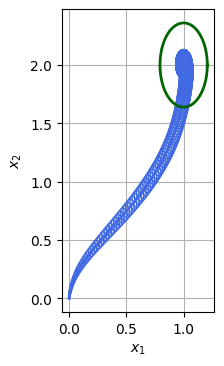

In [6]:

plot_data_no_gp = EllipsoidData2D(
    center_data = X_no_gp[:,0:2],
    delta = X_no_gp[:,6],
    M = M_under[0:2,0:2]
)

plot_terminal_set = EllipsoidData2D(
    center_data = np.array([[1.0,2.0]]),  # reference state
    delta = np.array([constants_offline['delta_bar_0']]),
    M =  M_under[0:2,0:2]
)


fig, ax = base_plot( size=(5*cm,10*cm), lw=1.5)
add_plot_trajectory(ax, plot_data_no_gp, center_color = 'royalblue', lw_center=2,tube_color = 'royalblue', lw_tube=1)
add_plot_trajectory(ax, plot_terminal_set, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=0.1, lw_tube=2)
plt.grid()

# ax = plot_sol_tube_obstacle(plot_data_no_gp, obs_pos, 
#                        center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)



# Train GP model offline

### Get offline data

In [7]:
# Define offline training points (inputs)
torch.manual_seed(0)
phi_range = (-torch.pi/6, torch.pi/6)
v1_range = (-0.3,0.3)
v2_range = (-0.2,0.5)
n_pts_per_dim = 4
X_train_offline = generate_training_positions_as_grid(phi_range, v1_range, v2_range, n_pts_per_dim)
n_GP_inputs = X_train_offline.shape[1]
n_offline_data = X_train_offline.shape[0]

# Generate observation at training inputs
# Note: the function g_eval only takes the states defined in x_train_offline as inputs
noise_size = 0.01
y_train_offline = generate_g_outputs_at_training_inputs(g_eval, X_train_offline, noise_size)

# Prepare for batch GP
X_train_batch = torch.zeros((n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs))
Y_train_batch = torch.full((n_gp_models_in_batch, n_data_points_in_batch), float('nan'))

# Copy the original data into the new tensors
X_train_batch[:, :n_offline_data, :] = X_train_offline.tile(n_gp_models_in_batch, 1, 1) # size of training data (X) for the batch is (n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs)
Y_train_batch[:, :n_offline_data] = y_train_offline.tile(n_gp_models_in_batch, 1)       # size of training data (Y) for the batch is (n_gp_models_in_batch, n_data_points_in_batch)
batch_shape = torch.Size([n_gp_models_in_batch])

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Train model

In [8]:
# Initialize likelihood and model
torch.manual_seed(0)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape)  
gp_models_as_batch = BatchGPModel(X_train_batch, Y_train_batch, likelihood, batch_shape)

# Train the batch model 
gp_models_as_batch, likelihood = train_GP_models_as_batch_with_nan(gp_models_as_batch, likelihood, X_train_batch, Y_train_batch, training_iterations = 150)

# Set all hyperparameters to be the same for all GP in the batch
gp_models_as_batch, likelihood = set_hyperparameters_to_first_dimension(gp_models_as_batch, likelihood)

# Manually set a large length scale for testing
# with torch.no_grad(): 
    # gp_models_as_batch.covar_module.base_kernel.lengthscale = torch.tensor([[[100]],[[100]],[[100]],[[100]],[[100]],[[100]],[[100]],[[100]]])


# Print hyperparameters (all GP models sould have the same hyperparameters)
# print_hyperparameters_of_batch(gp_models_as_batch,likelihood)

# Set the model to evaluation mode
gp_models_as_batch.eval()
likelihood.eval()

Iter 1/150 - Loss: 2.148
Iter 2/150 - Loss: 2.040
Iter 3/150 - Loss: 1.931
Iter 4/150 - Loss: 1.822
Iter 5/150 - Loss: 1.713
Iter 6/150 - Loss: 1.602
Iter 7/150 - Loss: 1.490
Iter 8/150 - Loss: 1.377
Iter 9/150 - Loss: 1.263
Iter 10/150 - Loss: 1.149
Iter 11/150 - Loss: 1.033
Iter 12/150 - Loss: 0.915
Iter 13/150 - Loss: 0.797
Iter 14/150 - Loss: 0.678
Iter 15/150 - Loss: 0.557
Iter 16/150 - Loss: 0.435
Iter 17/150 - Loss: 0.312
Iter 18/150 - Loss: 0.188
Iter 19/150 - Loss: 0.064
Iter 20/150 - Loss: -0.062
Iter 21/150 - Loss: -0.189
Iter 22/150 - Loss: -0.316
Iter 23/150 - Loss: -0.444
Iter 24/150 - Loss: -0.573
Iter 25/150 - Loss: -0.702
Iter 26/150 - Loss: -0.832
Iter 27/150 - Loss: -0.962
Iter 28/150 - Loss: -1.093
Iter 29/150 - Loss: -1.224
Iter 30/150 - Loss: -1.356
Iter 31/150 - Loss: -1.488
Iter 32/150 - Loss: -1.620
Iter 33/150 - Loss: -1.752
Iter 34/150 - Loss: -1.884
Iter 35/150 - Loss: -2.016
Iter 36/150 - Loss: -2.148
Iter 37/150 - Loss: -2.280
Iter 38/150 - Loss: -2.412
It

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Plot initial GP models

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


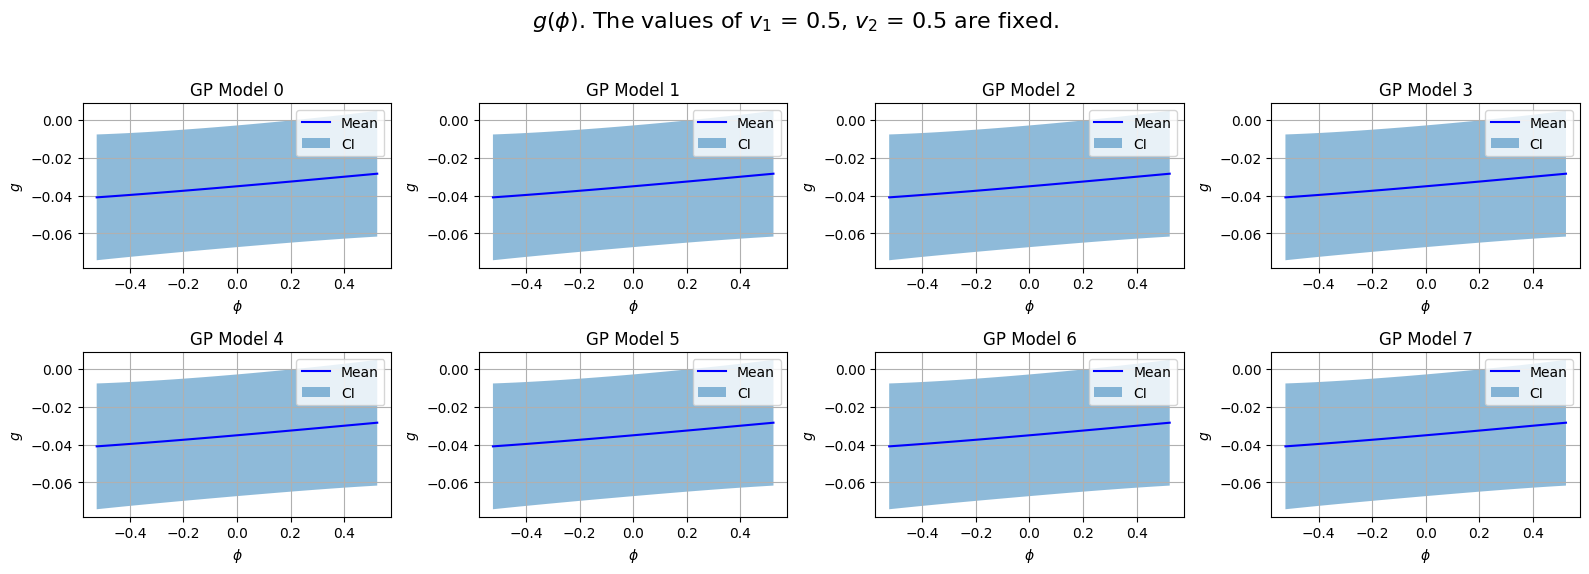

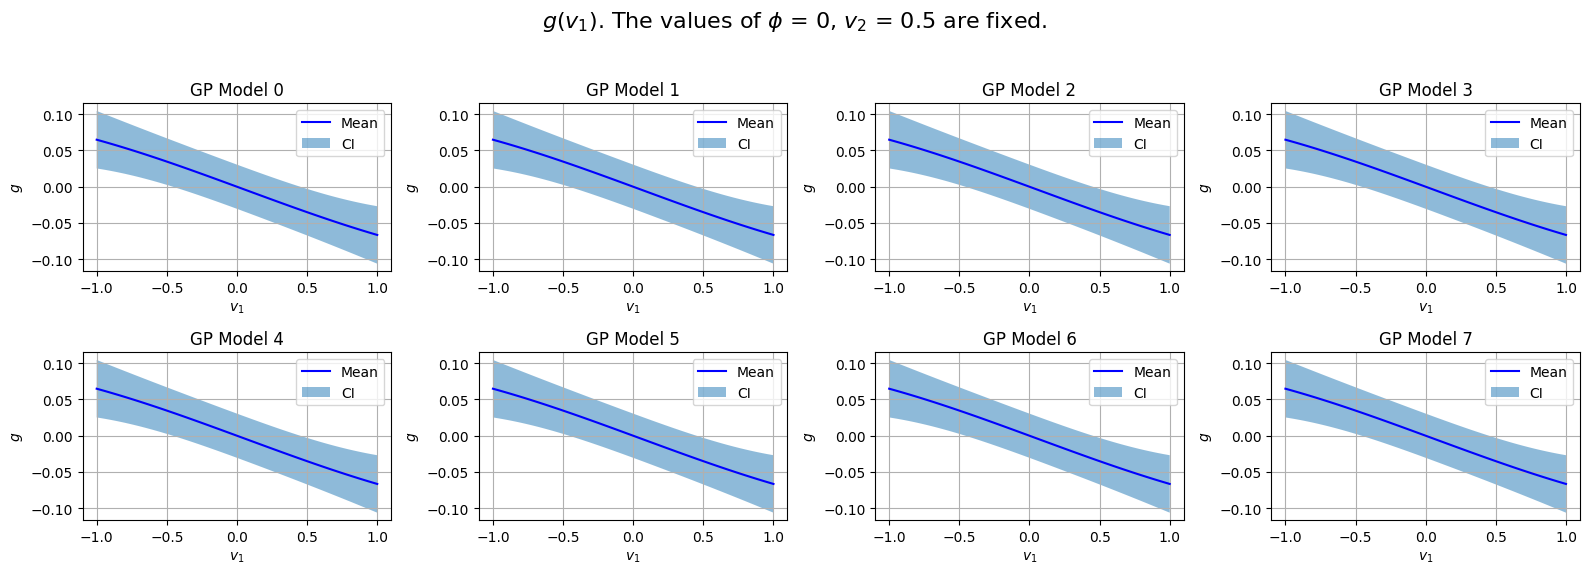

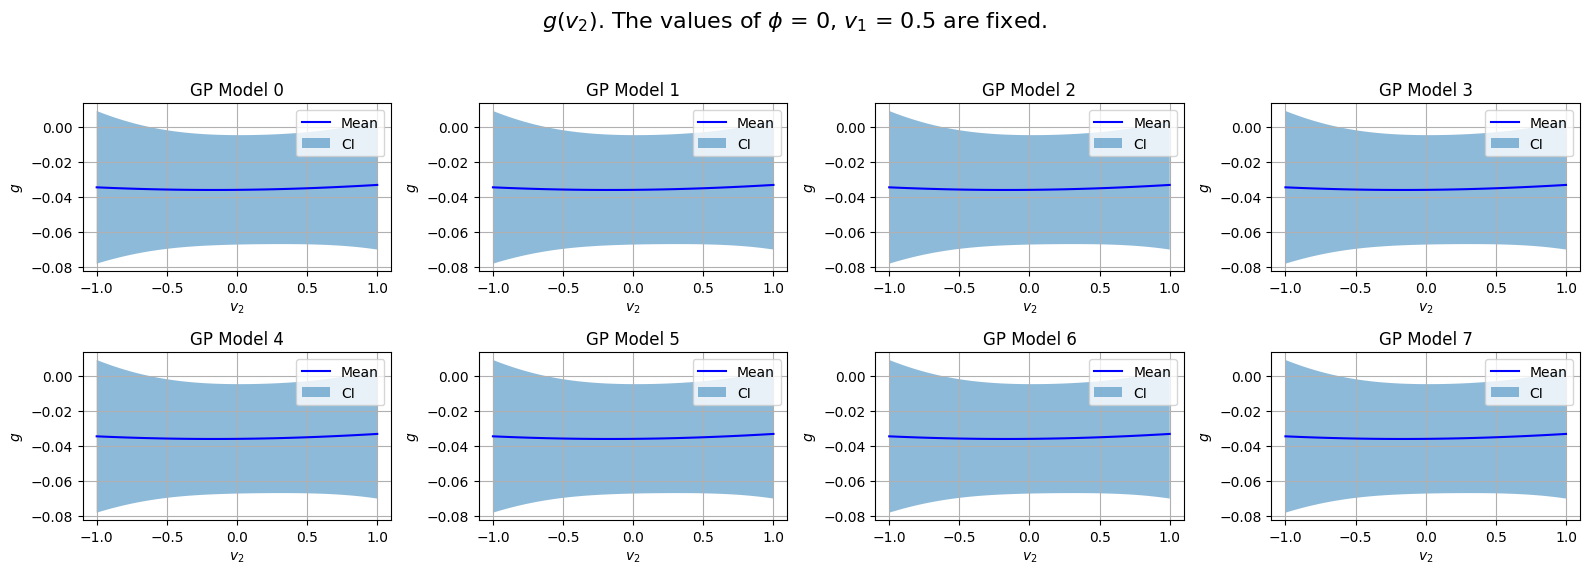

In [9]:
# Define range and fixed points at which to plot the functions
phi_range = (-torch.pi/6 , torch.pi/6)
v1_range = (-1., 1.)
v2_range = (-1., 1.)
fixed_phi = 0
fixed_v1 = 0.5
fixed_v2 = 0.5

with gpytorch.settings.observation_nan_policy("fill"):
    # Plot GP models with varied phi, fixed v1, and fixed v2
    plot_gp_models_in_batch_quadrotor(gp_models_as_batch, likelihood, phi_range, (fixed_v1, fixed_v2), 'phi', n_gp_models_in_batch, fig_size=(16,6))

    # Plot GP models with varied v1, fixed phi, and fixed v2
    plot_gp_models_in_batch_quadrotor(gp_models_as_batch, likelihood, v1_range, (fixed_phi, fixed_v2), 'v1', n_gp_models_in_batch, fig_size=(16,6))

    # Plot GP models with varied v2, fixed phi, and fixed v1
    plot_gp_models_in_batch_quadrotor(gp_models_as_batch, likelihood, v2_range, (fixed_phi, fixed_v1), 'v2', n_gp_models_in_batch, fig_size=(16,6))

# RMPC, with GP, open-loop

### Define residual model (with GP, trained on offline data)

In [10]:
# Define system dynamics with GP 
system_dynamics_g_bar = NonlinearSystemGP(B,G,f)  
tube_dynamics_w = TubeDynamicsGP(rho, L_G, G_M, E_M, beta)
single_GP_est_model = EstimateAndBoundSingleGP(gp_models_as_batch, beta, g_sys_state_idx) # use gp_models_as_batch, but only the first batch dimension, i.e., the first model in the batch is used in the estimator class
system_and_tube_dynamics_RMPC = SystemAndTubeDynamicsGP(system_dynamics_g_bar, tube_dynamics_w, single_GP_est_model)
time_integrator_RMPC = TimeIntegrator(system_and_tube_dynamics_RMPC,h,method="RK4")

# Create residual with GP
residual_model_gw_bar = ResidualTimeIntegration(time_integrator_RMPC)   

### Solve optimisation problem (open loop, 1 single solve)

In [11]:
ocp_RMPC_ol = export_ocp_quadrotor_RMPC(N, T, constants_offline, initial_con_z=True, terminal_con=True, soft_con=False, obstacle=False, x_ref = np.array([1.0,2.0,0.,0.,0.,0.]))
ocp_RMPC_ol.model.name = 'quadrotor_with_gp_soft_v1'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RMPC_ol.solver_options.integrator_type = "DISCRETE"
ocp_RMPC_ol.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RMPC_ol.solver_options.line_search_use_sufficient_descent=1
ocp_RMPC_ol.solver_options.levenberg_marquardt = 1.
ocp_RMPC_ol.solver_options.nlp_solver_max_iter = 200

# initialise solver
start_time_init_RMPC_ol = timeit.default_timer()
zoro_RMPC_ol = ResidualLearningMPC(
    copy.deepcopy(ocp_RMPC_ol),
    residual_model=residual_model_gw_bar,
    use_cython=False,
    path_json_ocp=ocp_RMPC_ol.model.name + '.json',
    build_c_code=True
)

X_init = np.zeros((N+1, system_and_tube_dynamics_RMPC.nx))  
U_init = np.ones((N, system_and_tube_dynamics_RMPC.nu))
# X_init =  X_no_gp      # use solution of case without GP as initial guess
# U_init = U_no_gp    

for i in range(N):   
    zoro_RMPC_ol.ocp_solver.set(i, "x", X_init[i,:])
    zoro_RMPC_ol.ocp_solver.set(i, "u", U_init[i,:])
zoro_RMPC_ol.ocp_solver.set(N, "x", X_init[N,:])
zoro_RMPC_ol.p_hat_nonlin[0, :] = np.repeat(0.,nx_system)
zoro_RMPC_ol.p_hat_nonlin[0, 0] = 0.0
zoro_RMPC_ol.p_hat_nonlin[0, 1] = 0.0


duration_init_RMPC_ol = timeit.default_timer() - start_time_init_RMPC_ol
print('Duration solver initialisation: {:.2f} s'.format(duration_init_RMPC_ol))

# solve optimisation problem
start_time_solve_RMPC_ol = timeit.default_timer()
zoro_RMPC_ol.solve(n_iter_max=40, tol_nlp=1e-05)
X_RMPC_ol,U_RMPC_ol = zoro_RMPC_ol.get_solution()
duration_solve_RMPC_ol = timeit.default_timer() - start_time_solve_RMPC_ol
print('Duration optimiser solution: {:.2f} s'.format(duration_solve_RMPC_ol))

       Type of constraints: Hard constraints
      Obstacle constraints: Absent
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_quadrotor_with_gp_soft_v1.so
rm -f quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_0_fun_jac_uxt_zt.o quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_0_fun.o quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_fun_jac_uxt_zt.o quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_fun.o quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_e_fun_jac_uxt_zt.o quadrotor_with_gp_soft_v1_constraints/quadrotor_with_gp_soft_v1_constr_h_e_fun.o acados_solver_quadrotor_with_gp_soft_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/b

### Simulate closed-loop real system based on open-loop optimal inputs

In [12]:
# Create real system dyanmics object
real_system_dynamics = NonlinearSystemReal(B,G,f_real,g)
# Initiate solution
X_real_system_cl_RMPC = np.zeros((N+1,nx_system))

# Simulate
for k in range(N):
    x_k = torch.tensor(np.float32(X_real_system_cl_RMPC[k,:])).unsqueeze(0) # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(X_RMPC_ol[k,:nx_system])).unsqueeze(0)    # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_RMPC_ol[k,0:nu_system])).unsqueeze(0)   # optimal input we just found for the first stage, shape (1,nu)
    x_next = simulate_real_system_RK4_1_sn_RMPC(real_system_dynamics, system_dynamics_g_bar, single_GP_est_model, g_sys_state_idx, x_k, z_k, v_k, Y_fcn, W_fcn, h)
    X_real_system_cl_RMPC[k+1,:] = x_next.detach().squeeze().numpy()

### Plot results

(<Figure size 670x400 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='$\\delta$'>)

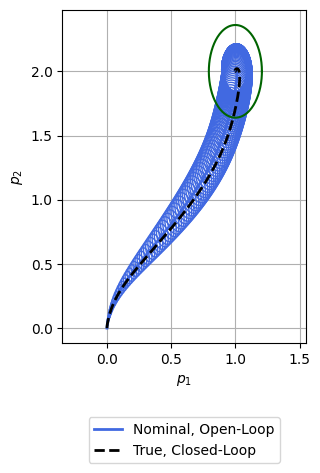

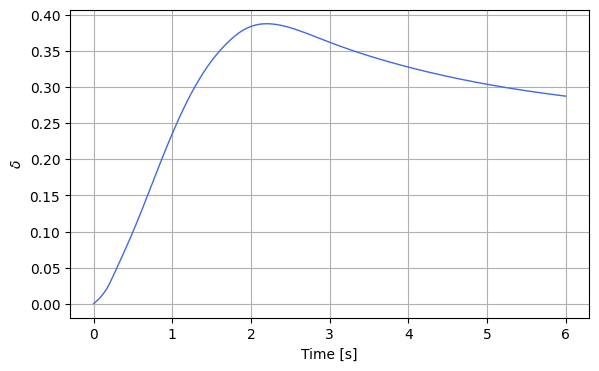

In [13]:
# Plot solution in the p1-p2 plane (position)
plot_data_RMPC_ol = EllipsoidData2D(
    center_data = X_RMPC_ol[:,0:2],
    delta = X_RMPC_ol[:,6],
    M = M_under[0:2,0:2]    # TODO: change to full matrix M(x)?
)

plot_terminal_set = EllipsoidData2D(
    center_data = np.array([[1.0,2.0]]),  # reference state
    delta = np.array([constants_offline['delta_bar_0']]),
    M =  M_under[0:2,0:2]
)

plot_data_real_system = EllipsoidData2D(
    center_data = X_real_system_cl_RMPC[:,0:2],
    delta = None,
    M = None
)


fig, ax = base_plot( size=(8*cm,11*cm), lw=1.5, x_label='$p_1$', y_label='$p_2$')
h1 = add_plot_trajectory(ax, plot_data_RMPC_ol, center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)
h2 = add_plot_trajectory(ax, plot_data_real_system,  center_color = 'k', center_linestyle='--',lw_center=2, z_order=20)
h3 = add_plot_trajectory(ax, plot_terminal_set, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=0.1, lw_tube=1.5)
lgd = ax.legend([h1[0], h2[0]], ['Nominal, Open-Loop', 'True, Closed-Loop'], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
plt.grid()
ax.axis('equal')

# fig.savefig('RMPC_with_true_sys_quadrotor.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')  


# Plot solution of all states and inputs as a function of time
# plot_state_input_solution_quadrotor(X_RMPC_ol, U_RMPC_ol, N, h)

# Plot delta over time
plot_single_state(X_RMPC_ol[:,6], N, h, '$\delta$', fig_size=(6.7, 4))


# ax = plot_sol_tube_obstacle(plot_data_RMPC_ol, obs_pos,
#                        center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)




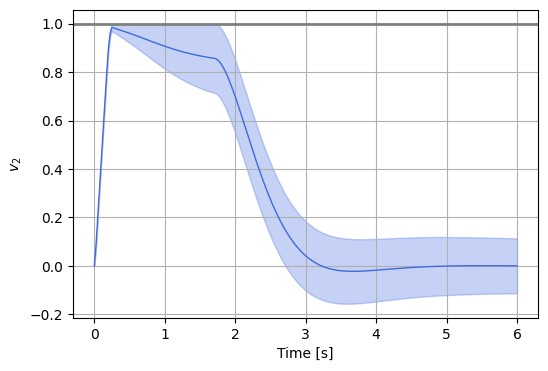

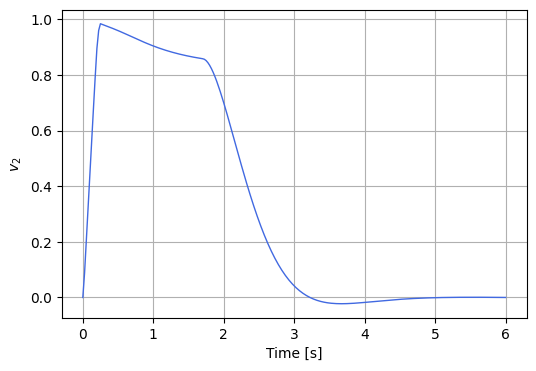

In [14]:
# 0-3: ub, lb p1,p2, then 4-7:  ub phi,v1,v2,phidot, 8-11: lb phi,v1,v2,phidot
idx_cx = 6
idx_var = 4
fig, ax = plot_single_state(X_RMPC_ol[:,idx_var],N,h,'$v_2$', c=c_x[idx_cx], delta=X_RMPC_ol[:,6], color_tube='royalblue', alpha_tube=0.3)
ax.axhline(constants_offline['b_x'][idx_cx], lw=2.0, color='grey')
fig.savefig('quadrotor_velocity.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')  

fig, ax = plot_single_state(X_real_system_cl_RMPC[:,4],N,h,'$v_2$')




# RMPC, with GP, closed-loop

### Define real system

In [15]:
# Create real system dyanmics object
real_system_dynamics = NonlinearSystemReal(B,G,f_real,g)

### Solver closed-loop MPC problem

In [16]:
# define constants
ocp_RMPC_cl = export_ocp_quadrotor_RMPC(N, T, constants_offline, initial_con_z=True, terminal_con=True, soft_con=True, obstacle=False)
ocp_RMPC_cl.model.name = 'quadrotor_with_gp_cl_v1'


# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RMPC_cl.solver_options.integrator_type = "DISCRETE"
ocp_RMPC_cl.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RMPC_cl.solver_options.line_search_use_sufficient_descent=1
ocp_RMPC_cl.solver_options.levenberg_marquardt = 1.
ocp_no_gp.solver_options.nlp_solver_max_iter = 100

# define some constants
n_sim = 5
nx_ocp_RMPC = system_and_tube_dynamics_RMPC.nx
nu_ocp_RMPC = system_and_tube_dynamics_RMPC.nu

# store results
x_sim_store = np.zeros((nx_system,n_sim+1))  
z_sim_store = np.zeros((nx_system,n_sim+1))
sol_state_full_store = np.zeros((n_sim,N+1,system_and_tube_dynamics_RMPC.nx)) 
comp_time_list = [] 
n_iter_list = []
comp_time_per_QP_list = []

# initialise solver
zoro_RMPC_cl = ResidualLearningMPC(
    copy.deepcopy(ocp_RMPC_cl),
    residual_model=residual_model_gw_bar,
    use_cython=False,
    path_json_ocp=ocp_RMPC_cl.model.name + '.json',
    build_c_code=True
)

# set initial solution candidate/guess
X_init = X_RMPC_ol      # np.zeros((N+1, system_and_tube_dynamics_gw_bar.nx))
U_init = U_RMPC_ol     # np.ones((N, system_and_tube_dynamics_gw_bar.nu))

for k in range(n_sim):

    print('Solving step nr. {}/{}'.format(k,n_sim-1))  
    
    # set solver parameters
    for i in range(N):   
        zoro_RMPC_cl.ocp_solver.set(i, "x", X_init[i,:])
        zoro_RMPC_cl.ocp_solver.set(i, "u", U_init[i,:])
    zoro_RMPC_cl.ocp_solver.set(N, "x", X_init[N,:])
    zoro_RMPC_cl.p_hat_nonlin[0, :] = x_sim_store[:,k] 
    print(zoro_RMPC_cl.p_hat_nonlin[0, :])

    # solve
    start_time_solve_k = timeit.default_timer()
    zoro_RMPC_cl.solve(n_iter_max=15)

    # store computational time
    duration_solve_k = timeit.default_timer() - start_time_solve_k
    print('Duration optimiser solution: {:.2f} s'.format(duration_solve_k))
    comp_time_list.append(duration_solve_k)
    n_iter_k = zoro_RMPC_cl.solve_stats['n_iter']
    n_iter_list.append(n_iter_k)
    comp_time_per_QP_list.append(duration_solve_k/n_iter_k)

    # get and store solution
    X_sol_k,U_sol_k = zoro_RMPC_cl.get_solution()
    sol_state_full_store[k,:,:] = X_sol_k 
    z_sim_store[:,k] = X_sol_k[0,0:nx_system]

    # simulate real model over one sampling interval dt=h (1_sn: 1 single shooting node)
    x_k = torch.tensor(np.float32(x_sim_store[:,k])).unsqueeze(0)           # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(z_sim_store[:,k])).unsqueeze(0)           # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_sol_k[0,0:nu_system])).unsqueeze(0)     # optimal input we just found for the first stage, shape (1,nu)

    x_next = simulate_real_system_RK4_1_sn_RMPC(real_system_dynamics, system_dynamics_g_bar, single_GP_est_model, g_sys_state_idx, x_k, z_k, v_k, Y_fcn, W_fcn, h)
    x_sim_store[:,k+1] = x_next.detach().squeeze().numpy()

    # shift candidate solution for next solve
    X_init[:-1, :] = X_sol_k[1:, :]
    X_init[-1, :] = X_sol_k[-1, :]
    U_init[:-1, :] = U_sol_k[1:, :]
    U_init[-1, :] = U_sol_k[-1, :]

print('computational time per QP: ', comp_time_per_QP_list)

       Type of constraints: Soft constraints
      Obstacle constraints: Absent
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_quadrotor_with_gp_cl_v1.so
rm -f quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_0_fun_jac_uxt_zt.o quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_0_fun.o quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_fun_jac_uxt_zt.o quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_fun.o quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_e_fun_jac_uxt_zt.o quadrotor_with_gp_cl_v1_constraints/quadrotor_with_gp_cl_v1_constr_h_e_fun.o acados_solver_quadrotor_with_gp_cl_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/User

### Plot results

(<Figure size 1600x600 with 4 Axes>,
 array([[<Axes: xlabel='$t$', ylabel='$x$'>,
         <Axes: xlabel='$t$', ylabel='$\\phi, \\dot{\\phi}$'>],
        [<Axes: xlabel='$t$', ylabel='$v$'>,
         <Axes: xlabel='$t$', ylabel='$u$'>]], dtype=object))

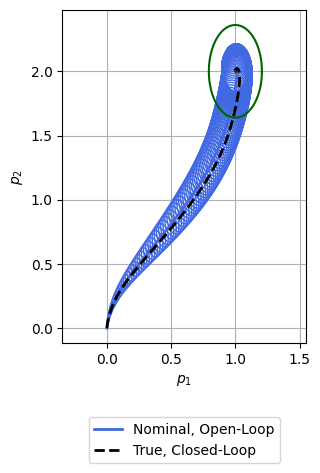

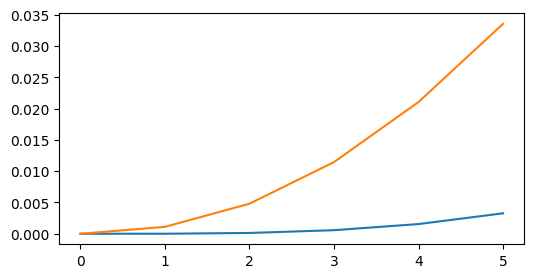

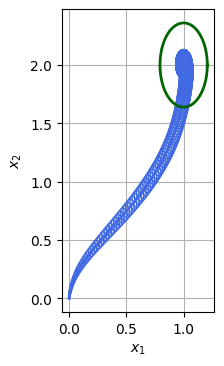

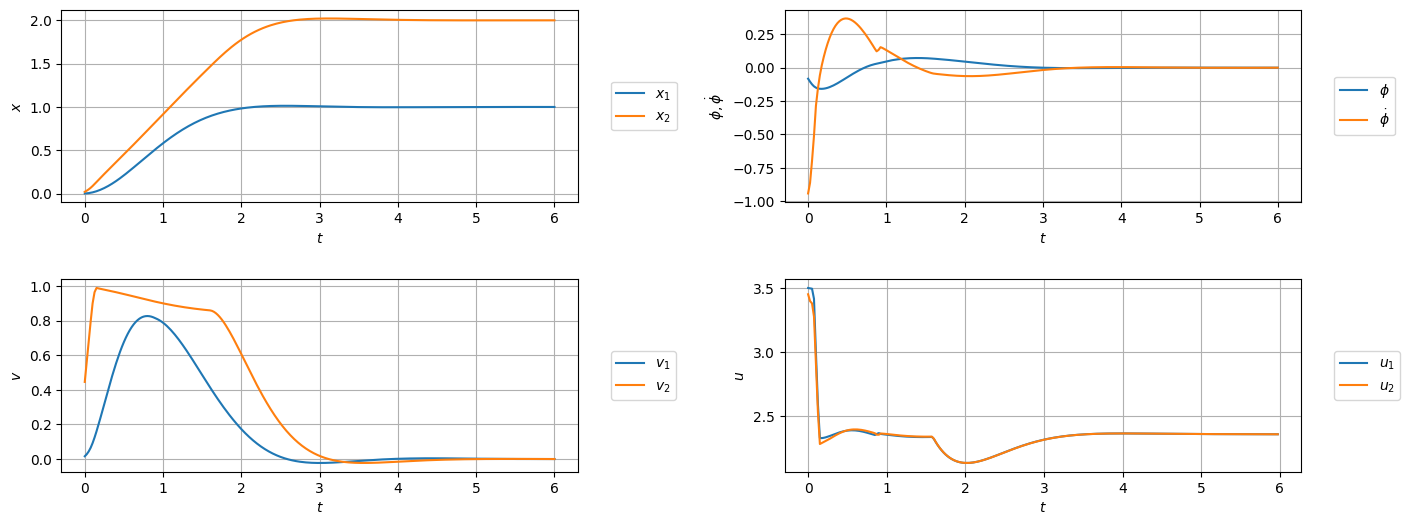

In [18]:
# Choose which solution (at which simulation step) to plot
X_sol_to_plot = sol_state_full_store[0,:,:]

# Plot solution in the p1-p2 plane (position)
plot_data_with_gp_RMPC = EllipsoidData2D(
    center_data = X_sol_to_plot[:,0:2],
    delta = X_sol_to_plot[:,6],
    M = M_under[0:2,0:2]    
)
# ax = plot_sol_tube_obstacle(plot_data_with_gp_RMPC, obs_pos,
                    #    center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)

fig, ax = base_plot( size=(8*cm,11*cm), lw=1.5, x_label='$p_1$', y_label='$p_2$')
h1 = add_plot_trajectory(ax, plot_data_with_gp_RMPC, center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)
h2 = add_plot_trajectory(ax, plot_data_real_system,  center_color = 'k', center_linestyle='--',lw_center=2, z_order=20)
h3 = add_plot_trajectory(ax, plot_terminal_set, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=0.1, lw_tube=1.5)
lgd = ax.legend([h1[0], h2[0]], ['Nominal, Open-Loop', 'True, Closed-Loop'], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
plt.grid()
ax.axis('equal')

# Plot real trajectory
fig,ax =plt.subplots(1,1,figsize=(6,3))
ax.plot(x_sim_store[0,:])
ax.plot(x_sim_store[1,:])

fig, ax = base_plot( size=(5*cm,10*cm), lw=1.5)
add_plot_trajectory(ax, plot_data_no_gp, center_color = 'royalblue', lw_center=2,tube_color = 'royalblue', lw_tube=1)
add_plot_trajectory(ax, plot_terminal_set, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=0.1, lw_tube=2)
plt.grid()

# Plot solution of all states and inputs as a function of time
plot_state_input_solution_quadrotor(X_sol_k,U_sol_k, N, h)

# # Plot delta over time
# plot_single_state(X_sol_k[:,6], N, h, '$\delta$', fig_size=(6.7, 4))

# RAMPC, with GP, closed-loop

### Define real system

In [19]:
# Create real system dyanmics object
real_system_dynamics = NonlinearSystemReal(B,G,f_real,g)

### Define nominal model for OCP

In [22]:
# Define system dynamics with GP 
system_dynamics_g_bar = NonlinearSystemGP(B,G,f)
tube_dynamics_w = TubeDynamicsGP(rho, L_G, G_M, E_M, beta)
gp_beta_list =  [beta for number in range(n_gp_models_in_batch)]
active_gp_idx = [0] # only the first GP of the batch is used/active at the beginning
X_train_standard_format = X_train_offline   # tensor, shape: (n_data_offline, n_input)
y_train_standard_format = y_train_offline   # tensor, shape: (n_data_offline)
n_training_data_points = n_offline_data
multi_lambda_est_model = EstimateAndBoundMultiLambda(gp_models_as_batch, gp_beta_list,active_gp_idx, g_sys_state_idx) 
system_and_tube_dynamics_gw_bar_multi_lambda = SystemAndTubeDynamicsGPMultiLambda(system_dynamics_g_bar, tube_dynamics_w, multi_lambda_est_model)
time_integrator_gw_bar_multi_lambda = TimeIntegrator(system_and_tube_dynamics_gw_bar_multi_lambda,h)
time_integrator_gw_bar_multi_lambda.is_eliminate_GP = True

# Create residual with GP
residual_model_gw_bar_multi_lambda = ResidualTimeIntegration(time_integrator_gw_bar_multi_lambda)   
ocp_RAMPC = export_ocp_quadrotor_RAMPC(N, T, constants_offline,n_gp_models_in_batch, initial_con_z=True, terminal_con=True, soft_con=True,obstacle=True)
ocp_RAMPC.model.name = 'quadrotor_RAMPC_v2'


# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RAMPC.solver_options.integrator_type = "DISCRETE"
ocp_RAMPC.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RAMPC.solver_options.line_search_use_sufficient_descent=1
ocp_RAMPC.solver_options.levenberg_marquardt = 1.
ocp_RAMPC.solver_options.nlp_solver_max_iter = 100


       Type of constraints: Soft constraints
      Obstacle constraints: Present
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present


### Solve closed-loop RAMPC

In [23]:
# Define constants
n_sim = 3
nx_ocp_RAMPC = system_and_tube_dynamics_gw_bar_multi_lambda.nx
nu_ocp_RAMPC = system_and_tube_dynamics_gw_bar_multi_lambda.nu
tol_lambda_elimination = 0.01

# Store results
x_sim_store = np.zeros((nx_system,n_sim+1))
z_sim_store = np.zeros((nx_system,n_sim+1))
sol_state_full_store = np.zeros((n_sim,N+1,system_and_tube_dynamics_gw_bar_multi_lambda.nx)) 
comp_time_list = [] 
n_iter_list = []
comp_time_per_QP_list = []

# Initialise solver
zoro_RAMPC = ResidualLearningMPC(
    copy.deepcopy(ocp_RAMPC),
    residual_model=residual_model_gw_bar_multi_lambda,
    use_cython=False,
    path_json_ocp=ocp_RAMPC.model.name + '.json',
    build_c_code=True
)

# Set initial solution candidate/guess
X_init = np.zeros((N+1, nx_ocp_RAMPC))
U_init = np.ones((N, nu_ocp_RAMPC))

X_init[:,0:7] = X_RMPC_ol
U_init[:,0:2] = U_RMPC_ol

for k in range(n_sim):

    print('Solving step nr. {}/{}'.format(k,n_sim-1))  
    
    # Set solver parameters
    for i in range(N):   
        zoro_RAMPC.ocp_solver.set(i, "x", X_init[i,:])
        zoro_RAMPC.ocp_solver.set(i, "u", U_init[i,:])
    zoro_RAMPC.ocp_solver.set(N, "x", X_init[N,:])
    zoro_RAMPC.p_hat_nonlin[0, :] = x_sim_store[:,k] 
    # print(zoro_solver_with_gp_RAMPC.p_hat_nonlin[0, :])

    # Solve
    start_time_solve_k = timeit.default_timer()
    zoro_RAMPC.solve(n_iter_max=50, tol_nlp=1e-05)

    # Store computational time
    duration_solve_k = timeit.default_timer() - start_time_solve_k
    # print('Duration optimiser solution: {:.2f} s'.format(duration_solve_k))
    comp_time_list.append(duration_solve_k)
    n_iter_k = zoro_RAMPC.solve_stats['n_iter']
    n_iter_list.append(n_iter_k)
    comp_time_per_QP_list.append(duration_solve_k/n_iter_k)

    # Get and store solution
    X_sol_k,U_sol_k = zoro_RAMPC.get_solution()
    sol_state_full_store[k,:,:] = X_sol_k 
    z_sim_store[:,k] = X_sol_k[0,0:nx_system]
    # print('Values of lambdas: ', U_sol_k[:,nu_system:])

    # Simulate real model over one sampling interval dt
    x_k = torch.tensor(np.float32(x_sim_store[:,k])).unsqueeze(0)           # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(z_sim_store[:,k])).unsqueeze(0)           # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_sol_k[0,0:nu_system])).unsqueeze(0)     # optimal input we just found for the first stage, shape (1,nu)
    lambda_k = torch.tensor(np.float32(U_sol_k[0,nu_system:])).unsqueeze(0) # optimal lambdas we just found for the first stage, shape (1,n_gp_models_in_batch)
                                      
    x_next = simulate_real_system_RK4_1_sn(real_system_dynamics, system_dynamics_g_bar, multi_lambda_est_model, g_sys_state_idx, x_k, z_k, v_k, lambda_k, Y_fcn, W_fcn, h)
    x_sim_store[:,k+1] = x_next.detach().squeeze().numpy()

    # Eliminate GP model if not used/needed
    if time_integrator_gw_bar_multi_lambda.is_eliminate_GP == True:
        # define useful list of indexes
        gp_model_all_idx = range(n_gp_models_in_batch)
        gp_model_idx_to_eliminate = []
    
        # reshape for looking at potential patterns: 4xN - 4 RK4 evalutations over N steps
        rk_reshape = 4
        w_bar_used_gp_models = np.array(zoro_RAMPC.residual_model.system_time_integrator.w_bar_gp_idx_list).reshape(rk_reshape,N)

        # loop over gp models and check if conditions are fulfilled
        for i in range(n_gp_models_in_batch):
            # condition 0: index i is corresponding to a GP model that can be used, and not a placholder in the batch
            if i in multi_lambda_est_model.active_gp_idx:
                # condition 1: not used in w_bar evaluation
                if not (i in zoro_RAMPC.residual_model.system_time_integrator.w_bar_gp_idx_list):
                    # condition 2: corresponding lambda value always 0 (i.e., GP model not used for estimate \bar{g})
                    lambda_values_index_i = U_sol_k[:,nu_system + i]
                    if np.all(lambda_values_index_i<=tol_lambda_elimination):
                        gp_model_idx_to_eliminate.append(i)
                        print('---------------')
                        print('GP at position ', i, ' can be eliminated')
                        print('---------------')

    
        # eliminate gp models not used in our gp models' collection
        active_gp_idx = [i for i in multi_lambda_est_model.active_gp_idx if i not in gp_model_idx_to_eliminate]

    # Acquire new data point based on system's evolution
    x_new = x_next[g_sys_state_idx]
    x_new = torch.transpose(x_new.detach(),0,1)  # get a tensor of size (1,3)
    g_new = generate_g_outputs_at_training_inputs(g_eval, x_new, noise_size)
    X_train_standard_format = torch.cat((x_new,X_train_standard_format))
    y_train_standard_format = torch.cat((g_new,y_train_standard_format))
    n_training_data_points += 1

    # Train/obtain new GP model
    free_indexes_in_batch = [i for i in range(n_gp_models_in_batch) if i not in active_gp_idx]  # obtain batch indexes of unactive GP models
    if not free_indexes_in_batch:
        print("No free spot in the GP batch. Continue without adding any new GP model ...")
    else:
        idx_new_gp_model = min(free_indexes_in_batch)
        print("Add new GP model at batch position ", idx_new_gp_model)
        X_train_batch[idx_new_gp_model,:n_training_data_points,:] = X_train_standard_format
        Y_train_batch[idx_new_gp_model,:n_training_data_points] = y_train_standard_format.squeeze() 
        gp_models_as_batch.set_train_data(inputs=X_train_batch, targets=Y_train_batch)

        # update active GP models' collection
        active_gp_idx.append(idx_new_gp_model)

    # Update residual model with new GP models' collection
    multi_lambda_est_model = EstimateAndBoundMultiLambda(gp_models_as_batch, gp_beta_list, active_gp_idx, g_sys_state_idx)
    print('Number of active GP: ', multi_lambda_est_model.n_active_gp)
    system_and_tube_dynamics_gw_bar_multi_lambda = SystemAndTubeDynamicsGPMultiLambda(system_dynamics_g_bar, tube_dynamics_w, multi_lambda_est_model)
    time_integrator_gw_bar_multi_lambda = TimeIntegrator(system_and_tube_dynamics_gw_bar_multi_lambda,h)
    time_integrator_gw_bar_multi_lambda.is_eliminate_GP = True
    residual_model_gw_bar_multi_lambda = ResidualTimeIntegration(time_integrator_gw_bar_multi_lambda)  
    zoro_RAMPC.residual_model = residual_model_gw_bar_multi_lambda

    # Shift candidate solution for next solve
    X_init[:-1, :] = X_sol_k[1:, :]
    X_init[-1, :] = X_sol_k[-1, :]
    U_init[:-1, :] = U_sol_k[1:, :]
    U_init[-1, :] = U_sol_k[-1, :]

print('computational time per outer zoro iteration: ', comp_time_per_QP_list)
comp_time_multi_lambda = comp_time_per_QP_list

rm -f libacados_ocp_solver_quadrotor_RAMPC_v2.so
rm -f quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_0_fun_jac_uxt_zt.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_0_fun.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_fun_jac_uxt_zt.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_fun.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_e_fun_jac_uxt_zt.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_e_fun.o acados_solver_quadrotor_RAMPC_v2.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_0_fun_jac_uxt_zt.o quadrotor_RAMPC_v2_constraints/quadrotor_RAMPC_v2_constr_h_0_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/mnt/c/Us

KeyboardInterrupt: 

### Plot results

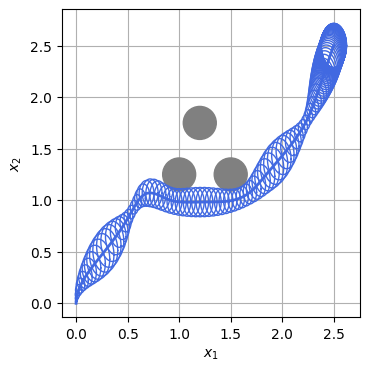

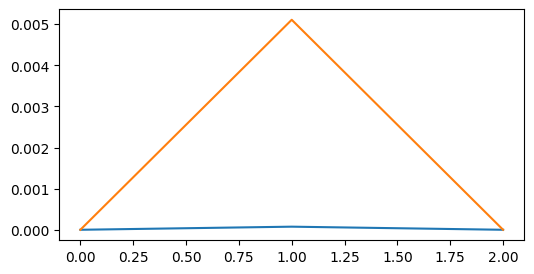

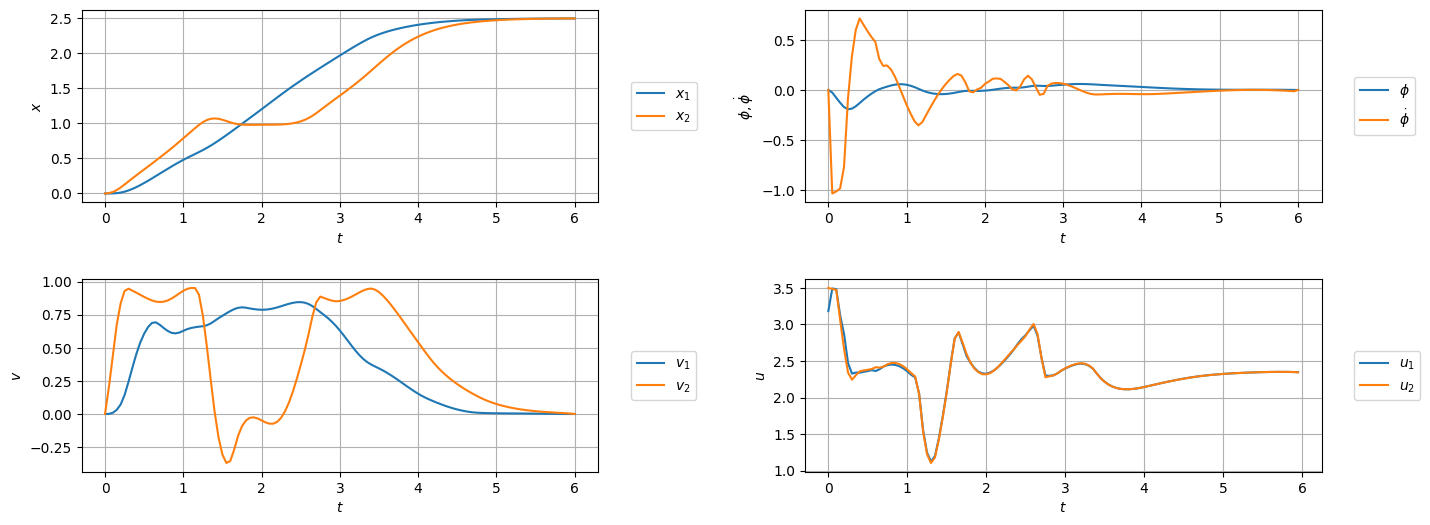

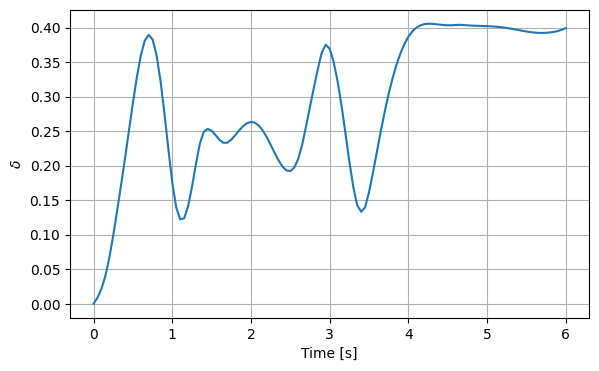

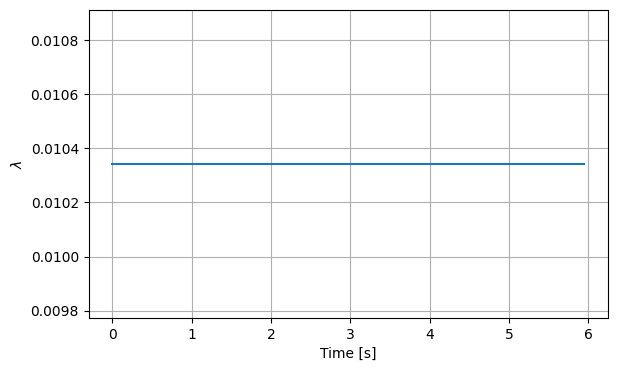

In [18]:
# Choose which solution (at which simulation step) to plot
X_sol_to_plot = sol_state_full_store[0,:,:]

# Plot solution in the p1-p2 plane (position)
plot_data_with_gp_RMPC = EllipsoidData2D(
    center_data = X_sol_to_plot[:,0:2],
    delta = X_sol_to_plot[:,6],
    M = M_under[0:2,0:2]    
)
plot_sol_tube_obstacle(plot_data_with_gp_RMPC, obs_pos,
                       center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)

# Plot real trajectory
fig,ax =plt.subplots(1,1,figsize=(6,3))
ax.plot(x_sim_store[0,:])
ax.plot(x_sim_store[1,:])

# Plot solution of all states and inputs as a function of time
plot_state_input_solution_quadrotor(X_sol_to_plot,U_sol_k, N, h)

# Plot delta over time
plot_single_state(X_sol_to_plot[:,6], N, h, '$\delta$', fig_size=(6.7, 4))

# Plot lambdas
plot_single_state(U_sol_k[:,4], N-1, h, '$\lambda$', fig_size=(6.7, 4))